<a href="https://colab.research.google.com/github/EdvardasDlugauskas/Auto-Rain/blob/master/vilniustransportOpenDataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing all libraries**

In [0]:
from os import listdir, path

import numpy as np
import pandas as pd

import torch
from torch import nn, optim, autograd, FloatTensor, LongTensor, manual_seed, randperm
import torch.nn.functional as F

from sklearn import model_selection, preprocessing

# **Importing data from csv files (pd.read_csv)**

add csv files which names is shown in this section

Need to have a `VTDeepLearn/data/` folder with CSV data files in your Google Drive (get them from here: [Mega link](https://mega.nz/file/fRxDmYgQ#vOPfSo0OJc51QpK8aTKYuBWZJMp89oszOoCE2m1b50s)).

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [180]:
DATA_FOLDER_PATH = "/content/drive/My Drive/VTDeepLearn/data"
file_names = sorted(listdir(DATA_FOLDER_PATH))[:7]
dataframes = [pd.read_csv(path.join(DATA_FOLDER_PATH, file)) for file in file_names]
all_data = pd.concat(dataframes).reset_index(drop=True)
all_data = all_data.drop(columns=['Number'])

print(file_names)
all_data.head()

['2016-04-25.csv', '2016-04-26.csv', '2016-04-27.csv', '2016-04-28.csv', '2016-04-29.csv', '2016-04-30.csv', '2016-05-01.csv']


,TransportType,StartStop,EndStop,ScheduledDeparture,ActualDeparture,ScheduledArrival,ActualArrival,IsHoliday
0,BUS,„Sparta“,Naujininkai,328,331,344,347,False
1,BUS,Naujininkai,Dariaus ir Girėno st.,346,351,361,364,False
2,BUS,„Sparta“,Stotis,367,367,385,384,False
3,BUS,„Sparta“,Dariaus ir Girėno st.,387,388,404,403,False
4,BUS,Prūsų st.,Felikso Vaitkaus st.,415,415,434,434,False


## Format data

Turn False/True to 0/1

Turn stop names into integers

Normalize time minute values

Turn transport type into classes

In [0]:
unique_stop_names = pd.Series(pd.concat([all_data['StartStop'], all_data['EndStop']]).unique()).reset_index().set_index(0).to_dict()['index']
all_data[['StartStop', 'EndStop']] = all_data[['StartStop', 'EndStop']].replace(unique_stop_names)

normalize_max = all_data[['ScheduledDeparture', 'ActualDeparture', 'ScheduledArrival', 'ActualArrival']].max().max()
all_data[['ScheduledDeparture', 'ActualDeparture', 'ScheduledArrival', 'ActualArrival']] = all_data[['ScheduledDeparture', 'ActualDeparture', 'ScheduledArrival', 'ActualArrival']] / normalize_max;

max_cat = max(unique_stop_names.values())
all_data['TransportType'] = all_data['TransportType'].replace({"BUS": max_cat + 1, "EXP_BUS": max_cat + 2, "TROL": max_cat + 3})
all_data['IsHoliday'] = all_data['IsHoliday'].replace({False: max_cat + 4, True: max_cat + 5})
max_cat = max_cat + 5;


In [183]:
all_data.head()

,TransportType,StartStop,EndStop,ScheduledDeparture,ActualDeparture,ScheduledArrival,ActualArrival,IsHoliday
0,611,0,1,0.198307,0.200121,0.207981,0.209794,614
1,611,1,268,0.209190,0.212213,0.218259,0.220073,614
2,611,0,6,0.221886,0.221886,0.232769,0.232164,614
3,611,0,268,0.233978,0.234583,0.244256,0.243652,614
4,611,2,3,0.250907,0.250907,0.262394,0.262394,614


In [0]:
cont_test_data = all_data[['ScheduledDeparture', 'ActualDeparture', 'ScheduledArrival']].to_numpy()
cat_test_data = all_data[['TransportType', 'StartStop', 'EndStop', 'IsHoliday']].to_numpy()
y_test_data = all_data['ActualArrival'].to_numpy().reshape(-1, 1)

test_sets = model_selection.train_test_split(cont_test_data, cat_test_data, y_test_data)
train_cont, test_cont = map(lambda x: autograd.Variable(FloatTensor(x), requires_grad=True), test_sets[0:2])
train_cat, test_cat = map(lambda x: autograd.Variable(LongTensor(x)), test_sets[2:4])
train_y, test_y = map(lambda x: autograd.Variable(FloatTensor(x)), test_sets[4:6])

In [186]:
net = Net()
net

Net(
  (emb_layer): Embedding(666, 5)
  (first_layer): Linear(in_features=8, out_features=20, bias=True)
  (second_layer): Linear(in_features=20, out_features=10, bias=True)
  (output_layer): Linear(in_features=10, out_features=1, bias=True)
  (generic_relu): LeakyReLU(negative_slope=0.01)
)

In [217]:
t = torch.rand(4, 3)
print(t)
print(t[:, -1])

tensor([[0.3772, 0.7827, 0.3272],
        [0.8305, 0.1772, 0.4494],
        [0.8366, 0.8565, 0.8024],
        [0.5920, 0.0498, 0.4221]])
tensor([0.3272, 0.4494, 0.8024, 0.4221])


In [0]:
class Net(nn.Module):

  def __init__(self):

    super().__init__()

    embed_dict_size = max_cat + 1

    embed_dim = 5

    # Embedding layer
    self.emb_layer = nn.Embedding(embed_dict_size, embed_dim)

    # Linear Layers
    self.first_layer = nn.Linear(embed_dim + 3, 20);
    self.second_layer = nn.Linear(20, 10);
    self.output_layer = nn.Linear(10, 1);

    self.generic_relu = nn.LeakyReLU();

  def forward(self, cont_data, cat_data):
    cat_embedded = self.emb_layer(cat_data)

    x = self.first_layer(torch.cat([cat_embedded[:, -1, :], cont_data], dim=1))
    x = self.generic_relu(x)
    
    x = self.second_layer(x)
    x = self.generic_relu(x)

    x = self.output_layer(x)

    return x

In [203]:
manual_seed(3)

net = Net()

optimizer = optim.SGD(net.parameters(), lr=0.1)
loss_func = nn.MSELoss()
batch_size = train_cont.size()[0] // 20

val_loss_history = []
train_loss_history = []

for epoch in range(5000):
    net.train()

    data_len = train_cont.size()[0];
    permutation = randperm(data_len)

    epoch_losses = []
    for batch_i in range(0, data_len, batch_size):
        indices = permutation[batch_i:batch_i+batch_size]
        cont_batch_x = train_cont[indices]
        cat_batch_x = train_cat[indices]
        batch_y = train_y[indices]

        outputs = net(cont_batch_x, cat_batch_x)
        loss = loss_func(outputs, batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
    
    train_loss_history.append(np.mean(epoch_losses))

    net.eval()
    y_hat = net(test_cont, test_cat) 

    val_loss = loss_func(y_hat, test_y).item()
    val_loss_history.append(val_loss)

    if not epoch % 10:
        print(f"Epoch: {epoch}, loss: {val_loss}")

    


print('Finished Training')

Epoch: 0, loss: 0.03277856111526489
Epoch: 10, loss: 0.0033963194582611322
Epoch: 20, loss: 0.0001832828129408881
Epoch: 30, loss: 0.00013787198986392468
Epoch: 40, loss: 0.00010801159078255296
Epoch: 50, loss: 7.98785185907036e-05
Epoch: 60, loss: 5.6689470511628315e-05
Epoch: 70, loss: 4.2657640733523294e-05
Epoch: 80, loss: 3.660886432044208e-05
Epoch: 90, loss: 3.34377218678128e-05
Epoch: 100, loss: 3.1144634704105556e-05
Epoch: 110, loss: 2.963621409435291e-05
Epoch: 120, loss: 2.857838262571022e-05
Epoch: 130, loss: 2.7792335458798334e-05
Epoch: 140, loss: 2.7230174964643084e-05
Epoch: 150, loss: 2.67877803707961e-05
Epoch: 160, loss: 2.646006760187447e-05
Epoch: 170, loss: 2.6213059754809365e-05
Epoch: 180, loss: 2.6021576559287496e-05
Epoch: 190, loss: 2.5878329324768856e-05
Epoch: 200, loss: 2.5789146093302406e-05
Epoch: 210, loss: 2.571606819401495e-05
Epoch: 220, loss: 2.563503585406579e-05
Epoch: 230, loss: 2.5569868739694357e-05
Epoch: 240, loss: 2.5508807084406726e-05
Epo

KeyboardInterrupt: ignored

# Plot

In [0]:
from matplotlib import pyplot as plt

## Train loss vs test loss

([<matplotlib.lines.Line2D at 0x7fbc1c1ea080>],
 [<matplotlib.lines.Line2D at 0x7fbc1c1ea048>])

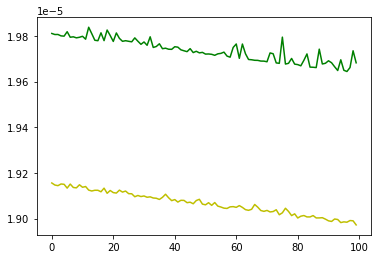

In [205]:
plt.plot(train_loss_history[-100:], c="y"), plt.plot(val_loss_history[-100:], c="g")

## Final model

In [0]:
y_hat = net(test_cont, test_cat)

(<matplotlib.collections.PathCollection at 0x7fbc1849e748>,
 <matplotlib.collections.PathCollection at 0x7fbc1849eac8>)

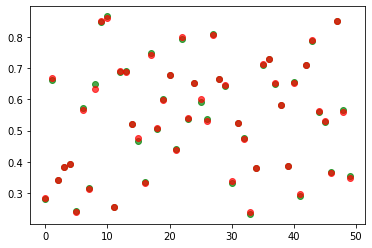

In [213]:
count = 50
plt.scatter(range(count),test_y.numpy()[:count], alpha=0.7, c='g'), plt.scatter(range(count), y_hat.detach().numpy()[:count], alpha=0.7, c='r')

# Resources & links

https://medium.com/@benjamin.phillips22/simple-regression-with-neural-networks-in-pytorch-313f06910379

https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/cifar10_tutorial.ipynb#scrollTo=RBCa4nG5wJAv

https://yashuseth.blog/2018/07/22/pytorch-neural-network-for-tabular-data-with-categorical-embeddings/
![alt text](https://yashuseth.files.wordpress.com/2018/07/model1.png)

Problem: model guessing the same number for all inputs (mean/baseline)

Solution: normalize input